> # Neural Network Basic - Week3 과제


## Import Library

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import sys
sys.path.append("/content/drive/MyDrive/ToBig's/week3")

In [9]:
import numpy as np
from matplotlib import pyplot as plt
from dataset.mnist import load_mnist

## Load Dataset
- MNIST 

In [10]:
(X_train, Y_train), (X_test, Y_test) = \
    load_mnist(normalize=True, one_hot_label=False)

In [11]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'Y_train shape: {Y_train.shape}')
print(f'Y_train shape: {Y_test.shape}')

X_train shape: (60000, 784)
X_test shape: (10000, 784)
Y_train shape: (60000,)
Y_train shape: (10000,)


## Activation Function 
- sigmoid & relu : hidden layer activation function 
- softmax : output layer activation function 

In [85]:
class sigmoid:
    # sigmoid 함수를 작성하세요
    def forward(x):
      sigmoid = []
      for xi in x:
        a = -xi
        si = 1 / (1 + np.exp(a))
        sigmoid.append(si)
      return sigmoid
    
    # sigmoid 함수의 미분을 작성하세요
    def backward(x):
      result = []
      for xi in x:
        a = -xi
        sigmoid = 1 / (1 + np.exp(a))
        ri = sigmoid * (1 - sigmoid)
        result.append(ri)
      return result

In [46]:
class relu:
    # relu 함수를 작성하세요
    def forward(x):
      relu =[]
      for xi in x:
        out_x = np.where(xi>0, xi, 0)
        relu.append(out_x)
      return relu
    
    # relu 함수의 미분을 작성하세요
    def backward(x):
      relu =[]
      for xi in x:
        out_x = np.where(xi>0, 1, 0)
        relu.append(out_x)

      return relu

In [14]:
class softmax:
    def forward(z):
        y = []
        for zi in z:
            c = np.max(zi)
            exp_zi = np.exp(zi-c)
            sum_exp_zi = np.sum(exp_zi)
            yi = exp_zi / sum_exp_zi
            y.append(yi)

        return np.array(y)
    
    def backward(p, y) :
        dp = p.copy()
        for dpi, yi in zip(dp, y):
            for k in range(dp.shape[1]):
                if k == yi :
                    dpi[k] -= 1
        return dp

## Loss Function

In [17]:
# 머신러닝 분류 모델의 발견된 확률 분포와 예측 분포 사이의 차이를 측정
def cross_entropy(p, y):
    loss = []
    for pi, yi in zip(p, y):
        for k in range(p.shape[1]):
            if k == yi:
                loss.append((-1) * (np.log(pi[k] + 1e-8))) 
    return loss

## Layer

In [16]:
class Layer:
    def __init__(self, input_size, output_size, std=1e-4) :
        self.input_size = input_size
        self.output_size = output_size
        self.bias = np.random.randn(output_size)
        self.weight = np.random.randn(input_size, output_size)*std

## Neural Network
- 각 메소드와 변수들의 역할을 주석으로 달아주세요! 

In [22]:
class CustomNet:
    # CustomNet을 선언할 때 생성되는 값들입니다.
    def __init__(self, lr=0.0001, epoch=500, batch_size=200):
        self.lr = lr
        self.epoch = epoch  
        self.batch_size = batch_size
        self.loss_function = cross_entropy 
        self.layers = []
        self.activations = [softmax] #활성화함수 리스트에 softmax
        self.nodes = []
    
    # Layer를 추가할 때 호출합니다
    def addLayer(self, Layer): 
        self.layers.append(Layer) #layer 리스트에 Layer 추가
        if not self.nodes: 
            self.nodes.append(np.zeros(Layer.input_size)) #노드가 없을 시, 레이어 input size 만큼의 0행렬을 노드에 추가
        self.nodes.append(np.zeros(Layer.output_size)) #노드에 레이어 output size 만큼의 0행렬을 노드에 추가
        
    # Activation Function을 추가할 때 호출합니다
    def addActivation(self, Activation):
        tmp = self.activations.pop() #이미 activations 리스트에 들어가 있는 활성화 함수 뽑아내어 tmp에 저장
        self.activations.append(Activation) # activations 리스트에 추가할 활성화 함수 추기
        self.activations.append(tmp) #tmp를 다시 추가 ==> 원래 존재하는 활성화 함수에 새로운 활성화 함수 추가한 형태
        
    # 순전파 함수
    def _forward(self, X):
        self.nodes[0] = X.copy() #첫번째 노드에 입력값 copy
        output = X.copy() 
        for i in range(len(self.layers)): # 레이어만큼 반복
            Layer = self.layers[i] 
            Activation = self.activations[i] 
            output = np.dot(self.nodes[i], Layer.weight) #노드와 가중치를 내적
            output = output+ Layer.bias 
            output = Activation.forward(output) #output을 활성화 함수에 대입
            self.nodes[i+1] = output #다음 노드에 outout 대입
        return output   
    
    # 역전파 함수
    def _backward(self, X, output, y) :
        for i in reversed(range(len(self.layers))): #리스트의 원소를 거꾸로 뒤집고 이를 반환하는 reversed()
            a = self.nodes[i+1] 
            Layer = self.layers[i] 
            Activation = self.activations[i] 
            
            if i+1 == len(self.layers): # 처음 대입 시
                error = Activation.backward(output, y)
            else:
                error *= Activation.backward(a)
            Layer.weight -= np.dot(error.T, self.nodes[i]).T*self.lr/X.shape[0] #학습률에 따라 업데이트
            Layer.bias -= error.sum(axis=0)*self.lr/X.shape[0]
            error = np.dot(error, Layer.weight.T) 
            
    # Accrucy를 반환합니다
    def _accuracy(self, output, y):
        pre_p = np.argmax(output, axis=1) #배열에서 가장 높은 값을 반환하는 argmax() / axis = 1이므로 각 행에서 최댓값을 가지는 인덱스 위치 반환
        return np.sum(pre_p==y)/y.shape[0] 
    
    # 데이터셋에 모델을 fit할때 호출합니다
    def fit(self, X, y, val_X, val_y):
        history = {'val_acc': [],'val_loss': []}
        N = X.shape[0]
        for i in range(self.epoch): #에포크 수 만큼 반복
            for j in range(N//self.batch_size): 
                batch_mask = np.random.choice(N, self.batch_size)
                X_batch = X[batch_mask] 
                y_batch = y[batch_mask] 
                output = self._forward(X_batch) 
                self._backward(X_batch, output, y_batch)
            
            #accuracy와 loss를 기록해둡시다
            output = self._forward(val_X) 
            history["val_acc"].append(self._accuracy(output, val_y)) 
            history["val_loss"].append(sum(self.loss_function(output, val_y))) 
            
            #중간중간 기록을 찍어볼 때 사용. 적절히 조절해 쓰세요
            if i % 10 == 0:
                print(i, "test accuracy :", history["val_acc"][-1])
                print(i, "test loss     :", history["val_loss"][-1])
        return history

## Customizing
- Network parameter, Layer architecture, Activation function .. 등등 다양한 하이퍼파라미터를 커스터마이징하여 높은 성능에 도달해 봅시다! 

In [47]:
# 하이퍼파라미터를 적절히 조절해 뉴럴넷을 선언하세요
nn = CustomNet(lr=0.005, epoch=100, batch_size=100)

# 총 3개의 레이어로 구성되도록 쌓기 / 활성화함수는 relu로 설정
nn.addLayer(Layer(784,256))
nn.addActivation(relu)
nn.addLayer(Layer(256,64))
nn.addActivation(relu)
nn.addLayer(Layer(64,10))

In [48]:
# 선언한 뉴럴넷의 구조입니다
for layer in nn.layers:
    print(layer.weight.shape, layer.bias.shape)

(784, 256) (256,)
(256, 64) (64,)
(64, 10) (10,)


In [49]:
history = nn.fit(X_train, Y_train, X_test, Y_test)

0 test accuracy : 0.1135
0 test loss     : 23013.354389019674
10 test accuracy : 0.1138
10 test loss     : 22626.945168586113
20 test accuracy : 0.2445
20 test loss     : 19841.174132073815
30 test accuracy : 0.5274
30 test loss     : 13646.798588861397
40 test accuracy : 0.7125
40 test loss     : 8327.388998478713
50 test accuracy : 0.8336
50 test loss     : 5635.869545710435
60 test accuracy : 0.8734
60 test loss     : 4434.981489496077
70 test accuracy : 0.8988
70 test loss     : 3668.701151923246
80 test accuracy : 0.9041
80 test loss     : 3495.7005655938524


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in subtract
  


90 test accuracy : 0.098
90 test loss     : nan


총 100번의 에포크를 시도했으나, 80과 90 사이에서 급격하게 정확도가 감소하는 것을 확인할 수 있었다.

In [59]:
# 하이퍼파라미터를 적절히 조절해 뉴럴넷을 선언하세요
#lr를 0.003로 조정 > loss값이 nan값이 나오지 않기 위해
nn2 = CustomNet(lr=0.003, epoch=100, batch_size=100)

# 총 3개의 레이어로 구성되도록 쌓기 / 활성화함수는 relu로 설정
nn2.addLayer(Layer(784,256))
nn2.addActivation(relu)
nn2.addLayer(Layer(256,64))
nn2.addActivation(relu)
nn2.addLayer(Layer(64,10))

In [56]:
history = nn2.fit(X_train, Y_train, X_test, Y_test)

0 test accuracy : 0.1135
0 test loss     : 22997.502567146243
10 test accuracy : 0.2072
10 test loss     : 22592.29594208708
20 test accuracy : 0.1711
20 test loss     : 21554.124806294327
30 test accuracy : 0.2813
30 test loss     : 18796.54724188732
40 test accuracy : 0.4847
40 test loss     : 14681.877610549063
50 test accuracy : 0.7164
50 test loss     : 8659.153243865108
60 test accuracy : 0.8091
60 test loss     : 6238.604627336883
70 test accuracy : 0.8357
70 test loss     : 5550.883871970476
80 test accuracy : 0.8535
80 test loss     : 5001.683468955467
90 test accuracy : 0.8729
90 test loss     : 4433.799371151757


In [57]:
print(history['val_acc'])
print(history['val_loss'])

[0.1135, 0.2064, 0.2082, 0.1161, 0.1377, 0.1233, 0.2087, 0.2089, 0.1995, 0.1975, 0.2072, 0.1914, 0.2072, 0.2544, 0.166, 0.2072, 0.2038, 0.1825, 0.1434, 0.1832, 0.1711, 0.1719, 0.1554, 0.1786, 0.1903, 0.1961, 0.2192, 0.2416, 0.2524, 0.259, 0.2813, 0.297, 0.3012, 0.347, 0.3622, 0.376, 0.3694, 0.4056, 0.435, 0.4666, 0.4847, 0.5061, 0.527, 0.5415, 0.5659, 0.5793, 0.6221, 0.6423, 0.6662, 0.6949, 0.7164, 0.7373, 0.7575, 0.7686, 0.7765, 0.7778, 0.7903, 0.7926, 0.7977, 0.8032, 0.8091, 0.8107, 0.8148, 0.8138, 0.8201, 0.8195, 0.8242, 0.8191, 0.8282, 0.83, 0.8357, 0.8363, 0.8365, 0.8405, 0.8411, 0.8451, 0.8463, 0.8502, 0.8502, 0.8526, 0.8535, 0.8576, 0.858, 0.8611, 0.8634, 0.8634, 0.8641, 0.8668, 0.8683, 0.8676, 0.8729, 0.8739, 0.8751, 0.877, 0.8773, 0.8814, 0.8818, 0.8831, 0.8848, 0.8855]
[22997.502567146243, 22990.19342597752, 22958.665856950523, 22934.560442213442, 22905.84767774574, 22873.059001995665, 22823.13187111442, 22775.46062595249, 22721.63333404082, 22661.815881621464, 22592.29594208

학습률을 0.003으로 설정했을때, loss가 꾸준히 감소하고, accuracy 역시 잘 상승하는 것을 볼 수 있었다. 따라서 에포크를 조금 더 진행해본다.

In [62]:
# 하이퍼파라미터를 적절히 조절해 뉴럴넷을 선언하세요
#lr를 0.003로 조정 > loss값이 nan값이 나오지 않기 위해
#에포크 증가
nn3 = CustomNet(lr=0.003, epoch=150, batch_size=100)

# 총 4개의 레이어로 구성되도록 쌓기 / 활성화함수는 relu로 설정
nn3.addLayer(Layer(784,256))
nn3.addActivation(relu)
nn3.addLayer(Layer(256,64))
nn3.addActivation(relu)
nn3.addLayer(Layer(64,10))

In [63]:
history = nn3.fit(X_train, Y_train, X_test, Y_test)

0 test accuracy : 0.1135
0 test loss     : 23001.51576322632
10 test accuracy : 0.184
10 test loss     : 22515.11938032075
20 test accuracy : 0.2094
20 test loss     : 21318.313182543607
30 test accuracy : 0.2899
30 test loss     : 19341.889809255994
40 test accuracy : 0.4266
40 test loss     : 15859.222834560582
50 test accuracy : 0.5168
50 test loss     : 14057.556294131411
60 test accuracy : 0.6444
60 test loss     : 11290.409739231287
70 test accuracy : 0.7364
70 test loss     : 8548.690752898972
80 test accuracy : 0.7915
80 test loss     : 7021.776292290419
90 test accuracy : 0.8653
90 test loss     : 4991.124186073122
100 test accuracy : 0.8852
100 test loss     : 4292.549300923125
110 test accuracy : 0.896
110 test loss     : 3849.177700252751
120 test accuracy : 0.903
120 test loss     : 3617.8133086533066
130 test accuracy : 0.9123
130 test loss     : 3307.934569641916
140 test accuracy : 0.9171
140 test loss     : 3033.993638181897


In [99]:
# 하이퍼파라미터를 적절히 조절해 뉴럴넷을 선언하세요
#시그모이드 함수를 통해서도 진행 시도
#lr를 0.008로 조정 > sigmoid 함수 사용 시 relu와 같게하면 정확도 향상이 잘 되지 않았음.
#에포크 증가 / 배치 사이즈 증가(배치사이즈 작을 시 정확도 향상되지 않음)
nn4 = CustomNet(lr=0.008, epoch=150, batch_size=400)

# 총 2개의 레이어로 구성되도록 쌓기 / 활성화함수는 sigmoid 사용
nn4.addLayer(Layer(784,64))
nn4.addActivation(sigmoid)
nn4.addLayer(Layer(64,10))

In [100]:
history = nn4.fit(X_train, Y_train, X_test, Y_test)

0 test accuracy : 0.1135
0 test loss     : 23027.995479329544
10 test accuracy : 0.1681
10 test loss     : 22770.704946175458
20 test accuracy : 0.2379
20 test loss     : 22272.959782839895
30 test accuracy : 0.3408
30 test loss     : 20799.786295659498
40 test accuracy : 0.4285
40 test loss     : 17864.16481752352
50 test accuracy : 0.5312
50 test loss     : 14759.524713949737
60 test accuracy : 0.5998
60 test loss     : 12329.88320983208
70 test accuracy : 0.6532
70 test loss     : 10621.024021425526
80 test accuracy : 0.7037
80 test loss     : 9340.871121995644
90 test accuracy : 0.7464
90 test loss     : 8289.80334554846
100 test accuracy : 0.7779
100 test loss     : 7434.401898338821
110 test accuracy : 0.7998
110 test loss     : 6746.051852418391
120 test accuracy : 0.8185
120 test loss     : 6196.641248886873
130 test accuracy : 0.832
130 test loss     : 5744.36197047562
140 test accuracy : 0.8447
140 test loss     : 5358.98953977797


시그모이드 함수를 활성화 함수로 사용한 경우, relu보다 학습률, 배치사이즈를 크게 잡아야 학습이 진행되는 것을 볼 수 있었다. 또한 레이어를 여러개 쌓았을 때 역시 정확도 향상이 잘 이루어지지 않았기에 레이어를 단순하게 2개만 추가했다.


같은 파라미터 조건에서 비교해보지 않아 정확한 판단은 아니지만, 시그모이드 함수를 사용했을 때의 정확도 향상이 더뎠다.

## Accuracy, Loss Visualization
- 자유롭게 Accuracy나 Loss를 시각화하여 확인하고 결과를 확인해 보세요! 

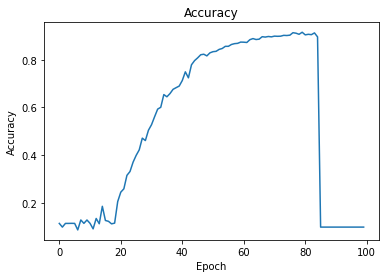

In [50]:
#100번의 에포크를 돌렸을 때 / 학습률 0.005 / relu 활성화함수
plt.plot(history['val_acc'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

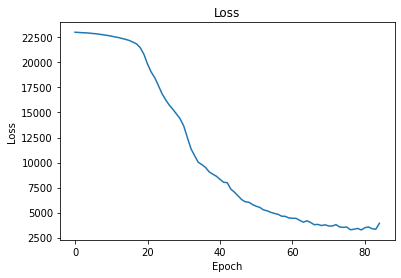

In [51]:
#100번의 에포크를 돌렸을 때 / 학습률 0.005 / relu 활성화함수
plt.plot(history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

80 초반대의 에포크까지는 꾸준히 loss가 감소하는 것을 볼 수 있었다. 따라서 다른 조건을 변경하지 않는다면 에포크를 80정도로 변경하는 것이 효과적일 것이다.
* 90부근부터는 loss가 nan으로 나오는데, 이것은 learning rate가 너무 높기 때문일 수 있다. 현재의 lr = 0.005에서 조금 더 작게 변경한다면 또한 해결할 수 있을 것이다.

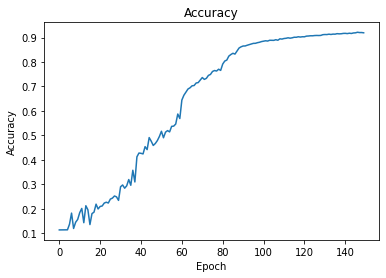

In [64]:
#150번의 에포크를 돌렸을 때 / 학습률 0.003 / relu 활성화함수
plt.plot(history['val_acc'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

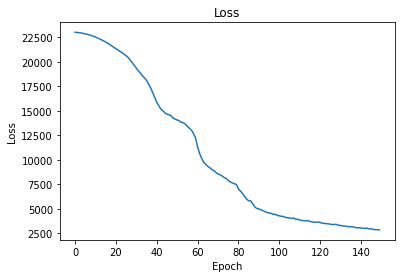

In [65]:
#150번의 에포크를 돌렸을 때 / 학습률 0.003 / relu 활성화함수
plt.plot(history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

더 성공적으로 정확도 향상이 이루어졌다.

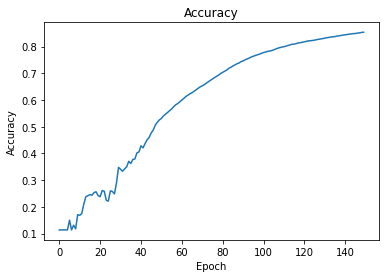

In [101]:
#150번의 에포크를 돌렸을 때 / 학습률 0.008 / 시그모이드 활성화함수
plt.plot(history['val_acc'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

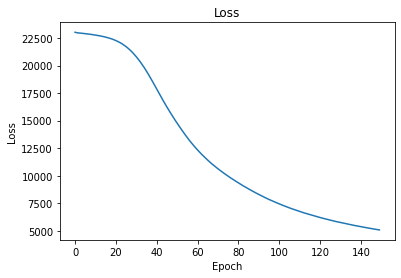

In [102]:
#150번의 에포크를 돌렸을 때 / 학습률 0.008 / 시그모이드 활성화함수
plt.plot(history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

시그모이드 함수를 활용했을 때, 정확도 향상과 loss 감소는 더뎠다. 그러나 시각화 해본 결과 더 매끄러운 변화가 진행되었음을 알 수 있다.